In [1]:
#!pip ... 터미널에서 쓰듯이 리눅스/터미널 명령어를 사용할 수 있게
!pip install finance-datareader

In [2]:
import FinanceDataReader as fdr

In [3]:
fdr.DataReader('005930') # ... 종목코드
# Open(시가) : 하루에 처음 가격
# High(고가) : 가장 높았던 가격
# Low(저가) : 가장 낮았던 가격
# Close(종가) : 가장 마지막 가격
# Volumne(거래량) : 사람들이 사고 판 주식 개수
# Change(전일대비 가격변화)

Open   High    Low  Close    Volume    Change
Date                                                      
1999-08-24   3800   3879   3730   3850    794226       NaN
1999-08-25   3850   4050   3850   3990   1126957  0.036364
1999-08-26   4040   4350   3970   4240   1429694  0.062657
1999-08-27   4300   4660   4220   4480   1298826  0.056604
1999-08-30   4520   4620   4340   4340    879129 -0.031250
...           ...    ...    ...    ...       ...       ...
2023-12-05  72300  72400  71200  71200  12129682 -0.019284
2023-12-06  71800  72100  71600  71700   8123087  0.007022
2023-12-07  71800  71900  71100  71500   8862017 -0.002789
2023-12-08  72100  72800  71900  72600  10859463  0.015385
2023-12-11  72800  73000  72200  73000   9406504  0.005510

[6000 rows x 6 columns]

<Axes: xlabel='Date'>

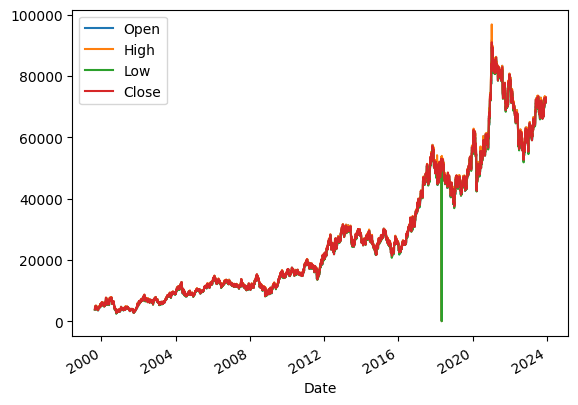

In [4]:
fdr.DataReader('005930').drop(columns=['Volume', 'Change']).plot()

In [5]:
fdr.chart.plot(fdr.DataReader('AAPL'))

None


In [6]:
fdr.chart.plot(fdr.DataReader('AMZN'))

None


In [7]:
fdr.chart.plot(fdr.DataReader('TSLA'))

None


In [8]:
fdr.chart.plot(fdr.DataReader('NFLX'))

None


<Axes: xlabel='Date'>

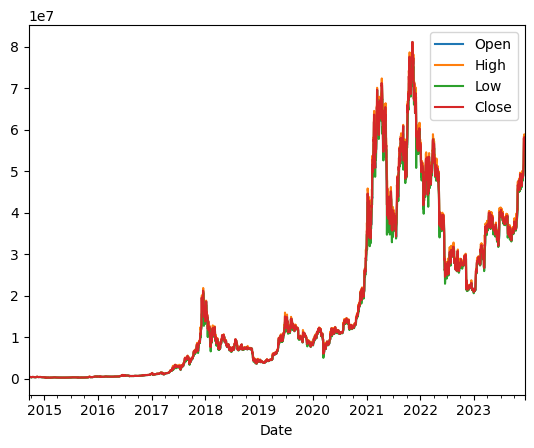

In [9]:
fdr.DataReader('BTC/KRW').drop(columns=['Volume']).plot()

In [10]:
import FinanceDataReader as fdr
import tensorflow as tf
import numpy as np

In [11]:
fdr.DataReader('069500')

Open   High    Low  Close   Volume    Change
Date                                                     
2002-10-14   5280   5415   5136   5263  2900729       NaN
2002-10-15   5314   5398   5211   5392  2575685  0.024511
2002-10-16   5442   5442   5353   5416  2294945  0.004451
2002-10-17   5403   5541   5330   5492  2353930  0.014032
2002-10-18   5625   5758   5589   5727  1486991  0.042790
...           ...    ...    ...    ...      ...       ...
2023-12-05  33585  33610  33370  33370  4349890 -0.010966
2023-12-06  33530  33675  33480  33480  7820757  0.003296
2023-12-07  33375  33505  33250  33350  9681266 -0.003883
2023-12-08  33630  33855  33615  33835  8598566  0.014543
2023-12-11  33905  33950  33690  33950  4485339  0.003399

[5234 rows x 6 columns]

In [12]:
# 4년치(365일 * 4 + 1일) 주식 데이터를 가져오기 위해 총 일수를 계산합니다.
days = 365 * 4 + 1

# FinanceDataReader(FDR) 라이브러리를 사용하여 '069500' 종목(KODEX 200 ETF)의 일별 주가 데이터를 가져옵니다.
# .Close를 사용하여 종가 정보만 추출합니다.
# .tail(days)를 사용하여 최근 days 일의 데이터를 선택하고,
# .values로 NumPy 배열로 변환하여 series 변수에 저장합니다.
series = fdr.DataReader('069500').Close.tail(days).values

# 시간 인덱스를 나타내는 배열을 생성합니다.
# np.arange(days)는 0부터 days-1까지의 정수를 생성하여 배열로 반환합니다.
time = np.arange(days)

In [13]:
series

array([29522, 29406, 29214, ..., 33350, 33835, 33950])

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # 1. 시계열 데이터를 텐서 데이터셋으로 변환합니다.
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # 2. 데이터를 윈도우로 분할합니다.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # window_size -> X. window_size + 1. y. label.

    # 3. 각 윈도우를 배치로 변환합니다.
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # 4. 데이터를 섞습니다.
    dataset = dataset.shuffle(shuffle_buffer)

    # 5. 입력과 출력을 나누고 배치로 묶습니다.
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size)

    # 6. 데이터를 미리 로드합니다.
    dataset = dataset.prefetch(1)

    # 데이터셋을 반환합니다.
    return dataset

In [15]:
# 1. 훈련(train)과 검증(valid) 데이터 분할을 위한 기준 지점 설정
# split_time = 365 # 훈련셋이 365개가 됨
split_time = len(series) - 365

# 2. 훈련 데이터의 시간 인덱스 생성
time_train = time[:split_time]

# 3. 훈련 데이터의 입력 데이터 생성
x_train = series[:split_time]

# 4. 검증 데이터의 시간 인덱스 생성
time_valid = time[split_time:]

# 5. 검증 데이터의 입력 데이터 생성
x_valid = series[split_time:]

# 6. 윈도우 크기 설정
window_size = 20 # 수정해서 다양하게 체크.

# 7. 배치 크기 설정
batch_size = 32 # 2배수? 32, 64...

# 8. 데이터 셔플링을 위한 버퍼 크기 설정
shuffle_buffer_size = len(series) - 365 # 맨앞의 검증셋이 아닌 데이터로....

# 9. windowed_dataset 함수를 사용하여 훈련 데이터셋 생성
#    - x_train: 훈련 데이터
#    - window_size: 윈도우 크기
#    - batch_size: 배치 크기
#    - shuffle_buffer_size: 데이터 셔플링을 위한 버퍼 크기
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [16]:
# 데이터셋을 확인하기 위한 데이터셋 생성
dataset_check = windowed_dataset(series, window_size, 1, shuffle_buffer_size)

# 첫 번째 배치의 입력과 출력을 출력합니다.
for feature, label in dataset_check.take(1):
    print(feature)  # 입력 데이터를 출력
    print(label)    # 출력 데이터를 출력

tf.Tensor(
[[27209 27195 27164 27064 26825 26882 26281 26318 26241 26180 26367 26562
  26599 26449 26528 26792 26712 26681 26618 26545]], shape=(1, 20), dtype=int64)
tf.Tensor([26676], shape=(1,), dtype=int64)


In [17]:
from keras.models import Sequential
from keras.layers import Dense

In [18]:
# Sequential 모델을 생성합니다.
model = Sequential([
    Dense(10, input_shape=[window_size], activation='relu'), # 입력 레이어 (입력 차원: window_size)
    Dense(10, activation='relu'), # 은닉 레이어 1
    Dense(1) # 출력 레이어
])

# 모델의 요약 정보를 출력합니다.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# 케라스(Keras)에서 Adam 옵티마이저를 가져옵니다.
from keras.optimizers import Adam

# 모델을 컴파일합니다.
# - loss: 손실 함수를 설정합니다. 'mse'는 평균 제곱 오차(Mean Squared Error)를 사용하는 것을 나타냅니다.
#   MSE는 회귀 문제에서 예측값과 실제값 사이의 오차를 측정하고 최소화하는데 사용됩니다.
# - optimizer: 옵티마이저를 설정합니다. 여기서는 Adam 옵티마이저를 사용하며, learning_rate를 1e-4로 설정합니다.
#   Adam 옵티마이저는 가중치 업데이트에 사용되며, learning_rate는 업데이트 속도를 조절하는 하이퍼파라미터입니다.
model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4)) # 0.0001

In [20]:
# 모델을 훈련합니다.
# - dataset: 훈련 데이터셋을 나타냅니다. 앞서 생성한 데이터셋을 사용합니다.
# - epochs: 에폭(epochs) 수를 설정합니다. 총 학습 반복 횟수를 나타냅니다.
#   여기서는 100번의 에폭을 설정하여 데이터를 100번 반복하여 학습합니다.
# - verbose: 학습 과정을 출력할 수 있는 옵션입니다. 0은 출력을 하지 않음을 나타냅니다.
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
34/34 [==============================] - 1s 4ms/step - loss: 954928960.0000
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 836707648.0000
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 728273600.0000
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 622204992.0000
Epoch 5/100
34/34 [==============================] - 0s 3ms/step - loss: 519057856.0000
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 420894464.0000
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 333085216.0000
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 254266400.0000
Epoch 9/100
34/34 [==============================] - 0s 2ms/step - loss: 185626608.0000
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 128179672.0000
Epoch 11/100
34/34 [==============================] - 0s 2ms/step - loss: 83578608.0000
Epoch 12/100
34/34 [===========

In [21]:
# 예측을 위한 시작 지점 설정
start_point = 1100

# 입력 데이터: start_point부터 start_point+window_size까지의 데이터를 선택합니다.
input_data = series[start_point:start_point+window_size]

# 출력 데이터: start_point+window_size 다음 시간 단계의 데이터를 선택합니다.
output_data = series[start_point+window_size]

# 모델을 사용하여 입력 데이터의 예측값을 계산합니다.
predicted_value = model.predict(input_data[np.newaxis])

1/1 [==============================] - 0s 84ms/step


In [22]:
# 예측값을 저장할 빈 리스트를 생성합니다.
forecast = []

# 시간을 반복하며 각 시점에서의 예측값을 계산하여 리스트에 추가합니다.
for time in range(len(series) - window_size):
    # 현재 시점부터 window_size 크기만큼의 데이터를 입력으로 사용하여 예측값을 계산합니다.
    prediction = model.predict(series[time:time + window_size][np.newaxis], verbose=1)

    # 예측값을 리스트에 추가합니다.
    forecast.append(prediction)

1/1 [==============================] - 0s 20ms/step


In [23]:
# 예측값 중 훈련 데이터 이후의 부분을 선택합니다.
forecast = forecast[split_time-window_size:]

# 예측값을 numpy 배열로 변환하고 첫 번째 열의 값만 선택합니다.
results = np.array(forecast)[:, 0, 0]

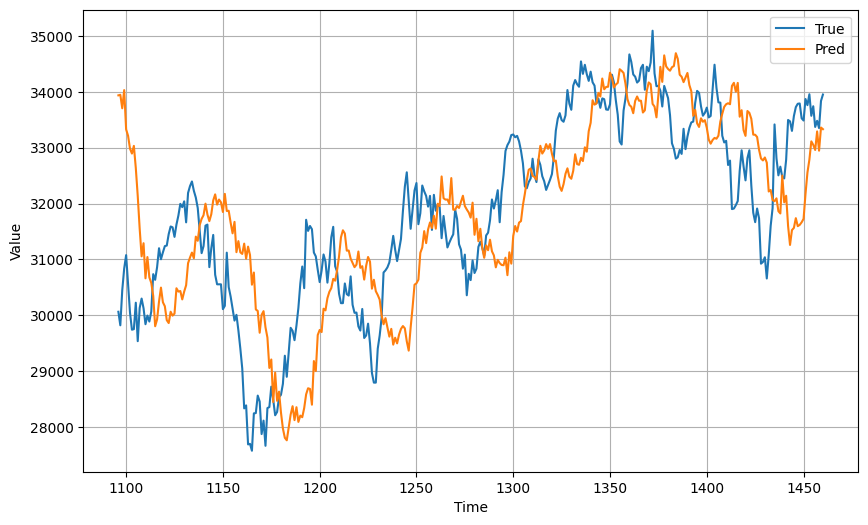

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# plot_series 함수 정의
def plot_series(time, series, format='-', start=0, end=None, label=None):
    # 시계열 데이터를 그래프로 표시합니다.
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')      # x 축 레이블 설정
    plt.ylabel('Value')     # y 축 레이블 설정
    plt.legend()            # 범례 표시
    plt.grid(True)          # 그리드 표시

# 실제값(time_valid, x_valid)과 예측값(results)을 그래프로 표시합니다.
plot_series(time_valid, x_valid, label='True')  # 실제값을 파란색 그래프로 표시
plot_series(time_valid, results, label='Pred')  # 예측값을 주황색 그래프로 표시
plt.show()  # 그래프 출력

In [25]:
from keras.metrics import mean_absolute_error

# 평균 절대 오차(MAE)를 계산하고 출력합니다.
print('mae : ', mean_absolute_error(x_valid, results).numpy())

mae :  1109.3285


In [26]:
# 1. DNN을 통해서 가격 예측하는 과정 반복해보기
# 2. 윈도우, 에포크, Dense - 레이어 수(Unit) ...  => 하이퍼 패러미터 수정해보기. / 종목코드를 바꿔서 데이터를 바꿔봐도 괜찮음.
# 질문. 요청있으면...?

In [27]:
#@title 학습률 튜닝하기

# 케라스(Keras)에서 제공하는 LearningRateScheduler를 가져옵니다.
from keras.callbacks import LearningRateScheduler

# LearningRateScheduler를 설정합니다.
# - lambda epoch: 1e-8 * 10**(epoch / 20):
#   - 학습률(learning rate)을 에폭(epoch)에 따라 동적으로 조정하는 함수를 정의합니다.
#   - 에폭이 증가함에 따라 학습률을 기하급수적으로 증가시킵니다.
#   - 이 함수는 학습 과정 중에 학습률을 조절하는 데 사용됩니다.
# 0.00000001 -> epoch 10^0 = 1 1e-8 -> 20, 1e-7. -> 40, 1e-6 -> 60 1e-5
# epoch -> 100. 1e-3. 0.001
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

In [28]:
# 케라스(Keras) 모델 아키텍처 정의
model = Sequential([
    Dense(10, input_shape=[window_size], activation='relu'),
    Dense(10, activation='relu'),
    Dense(1),
])

# 옵티마이저(optimizer) 설정
optimizer = Adam(learning_rate=1e-8)

# 모델 컴파일
# - loss='mse': 손실 함수(loss)로 평균 제곱 오차(Mean Squared Error, MSE)를 사용
# - optimizer: 앞서 설정한 Adam 옵티마이저를 사용
model.compile(loss='mse', optimizer=optimizer)

# 학습률 스케줄러(LearningRateScheduler)를 콜백(callbacks)으로 지정하여 학습 설정
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
34/34 [==============================] - 2s 4ms/step - loss: 1733766144.0000 - lr: 1.0000e-08
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 1733745280.0000 - lr: 1.1220e-08
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 1733721984.0000 - lr: 1.2589e-08
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 1733697792.0000 - lr: 1.4125e-08
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 1733658752.0000 - lr: 1.5849e-08
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 1733603712.0000 - lr: 1.7783e-08
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 1733546112.0000 - lr: 1.9953e-08
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 1733482880.0000 - lr: 2.2387e-08
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 1733412992.0000 - lr: 2.5119e-08
Epoch 10/100
34/34 [==========================

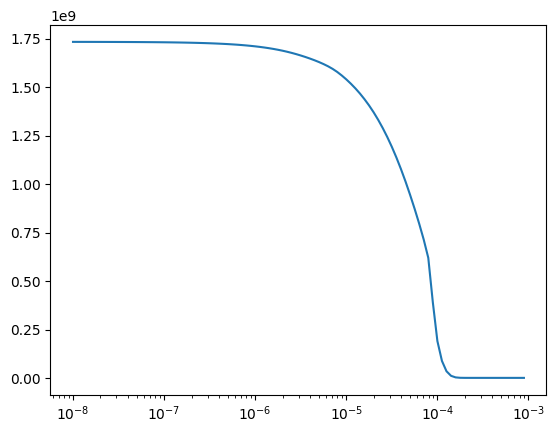

In [29]:
# 학습률 범위 설정
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# 손실(MSE) 값과 학습률 간의 관계를 그래프로 시각화
# - `plt.semilogx(lrs, history.history['loss'])`를 사용하여 학습률과 손실 사이의 관계를 그래프로 표시합니다.
# - `lrs`는 1e-8을 기준으로 지수 함수를 사용하여 100개의 다양한 학습률 값을 생성합니다.
# - x 축에는 학습률을 로그 스케일로 표시하고, y 축에는 손실(MSE) 값을 표시합니다.
plt.semilogx(lrs, history.history['loss'])

# 그래프를 화면에 출력
plt.show()

In [30]:
#@title 케라스 튜너
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [32]:
# https://keras.io/api/keras_tuner/hyperparameters/
# https://keras.io/api/keras_tuner/tuners/random/
def build_model(hp): # hyperparameter
# 모델을 빌드해주는 함수를 만듦 -> 그 함수에 여러가지 옵션중에 몇가지 혹은 특정 범위를 선택해서 모델을 자동으로 만듦
# 가장 최적화된 모델 찾아줌.

    # Sequential 모델을 생성합니다.
    model = Sequential()

    # 첫 번째 Dense 레이어를 추가합니다.
    # - 'units': 레이어의 뉴런 수를 하이퍼파라미터로 지정합니다.
    # - 'min_value', 'max_value', 'step': 뉴런 수의 범위와 간격을 설정합니다.
    # - 'activation': 활성화 함수로 ReLU(렐루)를 사용합니다.
    # - 'input_shape': 입력 데이터의 형태를 지정합니다. 'window_size'는 전역 변수로 설정되어 있습니다.
    model.add(Dense(
        units=hp.Int('units', min_value=10, max_value=30, step=20), # 10, 20, 30.
        activation='relu', input_shape=[window_size]))

    # 두 번째 Dense 레이어를 추가합니다.
    model.add(Dense(10, activation='relu'))

    # 출력 레이어를 추가합니다.
    model.add(Dense(1))

    # Adam 옵티마이저를 설정합니다.
    # - 'learning_rate': 학습률을 하이퍼파라미터로 설정합니다.
    # - 'ema_momentum': 지수 이동 평균 모멘텀을 하이퍼파라미터로 설정합니다.
    adam = Adam(learning_rate=1e-4,
                ema_momentum=hp.Choice('momentum', values=[.99, .9]))

    # 모델을 컴파일합니다.
    # - 손실 함수로 평균 제곱 오차(MSE)를 사용합니다.
    # - 앞서 설정한 Adam 옵티마이저를 사용합니다.
    model.compile(loss='mse', optimizer=adam)
    return model

from keras_tuner import RandomSearch

# RandomSearch 튜너 설정
tuner = RandomSearch(build_model,
                     objective='loss',  # 목표는 손실(MSE)을 최소화하는 것
                     max_trials=150,     # 시도할 하이퍼파라미터 조합의 최대 수
                     executions_per_trial=3,  # 각 조합당 실행 횟수
                     directory='my_dir',  # 결과 저장 디렉토리
                     project_name='hello')  # 프로젝트 이름

In [33]:
tuner.search(dataset, epochs=100, verbose=1)

Trial 4 Complete [00h 01m 43s]
loss: 1358676.4166666667

Best loss So Far: 763816.8958333334
Total elapsed time: 00h 06m 50s


In [34]:
tuner.results_summary() # 하이퍼파라미터 튜닝을 위한 모델 함수 정의

Results summary
Results in my_dir/hello
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 002 summary
Hyperparameters:
units: 10
momentum: 0.99
Score: 763816.8958333334

Trial 000 summary
Hyperparameters:
units: 30
momentum: 0.9
Score: 826727.3125

Trial 001 summary
Hyperparameters:
units: 30
momentum: 0.99
Score: 834220.0208333334

Trial 003 summary
Hyperparameters:
units: 10
momentum: 0.9
Score: 1358676.4166666667


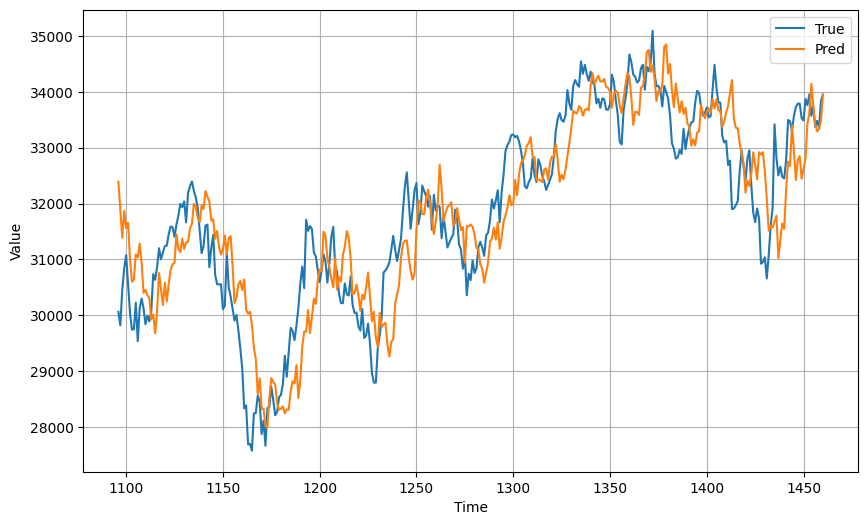

mae :  659.55225


In [35]:
model = Sequential([
    Dense(30, input_shape=[window_size], activation='relu'),
    Dense(10, activation='relu'),
    Dense(1),
])

model.compile(loss='mse',
    optimizer=Adam(learning_rate=1e-4, ema_momentum=.9))

model.fit(dataset, epochs=100, verbose=0)

forecast = []

for time in range(len(series) - window_size):
    prediction = model.predict(series[time:time + window_size][np.newaxis], verbose=0)
    forecast.append(prediction)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label='True')
plot_series(time_valid, results, label='Pred')
plt.show()

print('mae : ', mean_absolute_error(x_valid, results).numpy())